Epoch [0], Loss: 0.6142
Epoch [10], Loss: 0.4870
Epoch [20], Loss: 0.3981
Epoch [30], Loss: 0.3394
Epoch [40], Loss: 0.2977
Epoch [50], Loss: 0.2675
Epoch [60], Loss: 0.2470
Epoch [70], Loss: 0.2331
Epoch [80], Loss: 0.2232
Epoch [90], Loss: 0.2158
Accuracy: 90.00%
Recall (Sensitivity): 62.96%
Precision: 100.00%
F1-score: 77.27%


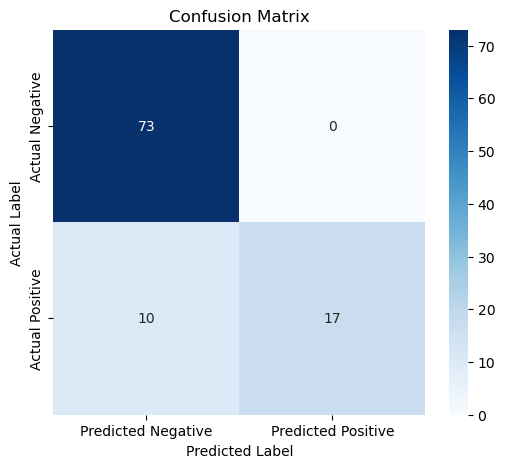

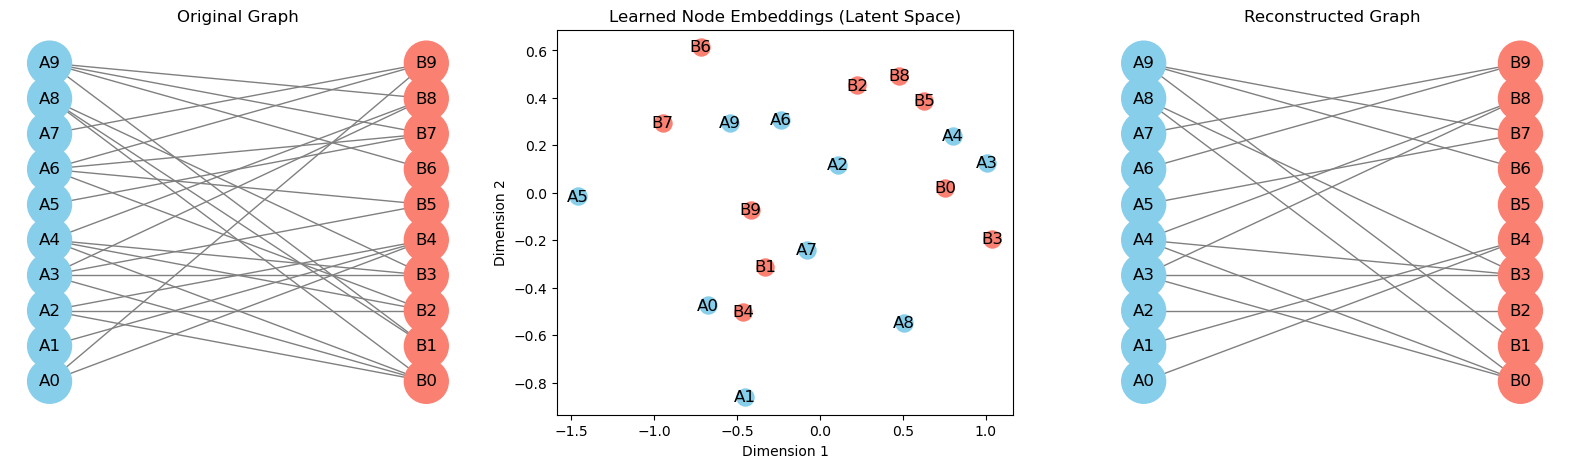

In [9]:
import networkx as nx
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import numpy as np
import math
import torch.optim as optim

# 1 Generate Bipartite Graph
random.seed(99)
num_nodes_set_1 = 10  # Left column
num_nodes_set_2 = 10 # Right column

nodes_set_1 = [f"A{i}" for i in range(num_nodes_set_1)]
nodes_set_2 = [f"B{i}" for i in range(num_nodes_set_2)]
all_nodes = nodes_set_1 + nodes_set_2

G = nx.Graph()
G.add_nodes_from(nodes_set_1, bipartite=0)
G.add_nodes_from(nodes_set_2, bipartite=1)

edges = []
for u in nodes_set_1:
    for v in nodes_set_2:
        if random.random() > 0.7:  # 50% chance of an edge
            G.add_edge(u, v)
            edges.append((u, v))

# 2️ Create the Data Matrix (Edge / Non-Edge Pairs)
datamatrix = []
for u in nodes_set_1:
    for v in nodes_set_2:
        label = 1 if (u, v) in edges or (v, u) in edges else 0
        u_idx = all_nodes.index(u)  # Convert node labels to indices
        v_idx = all_nodes.index(v)  # Convert node labels to indices
        datamatrix.append([label, u_idx, v_idx])  # Store indices instead of labels

datamatrix = np.array(datamatrix)

# Convert datamatrix to a PyTorch tensor
datamatrix_tensor = torch.tensor(datamatrix, dtype=torch.long)

# 3 Create intialization of embedding using Gaussian distribution
def initialize_embeddings_gaussian(num_nodes, embedding_dim):
    embeddings = {}
    sigma = 1.0 / math.sqrt(embedding_dim)
    for node in range(num_nodes):
        embeddings[node] = [random.gauss(0, sigma) for _ in range(embedding_dim)]
    return embeddings

num_nodes = num_nodes_set_1 + num_nodes_set_2
embedding_dim = 6
embeddings = initialize_embeddings_gaussian(num_nodes,embedding_dim)

embedding_tensor = torch.tensor(
    [embeddings[node] for node in range(num_nodes)],
    dtype=torch.float32, requires_grad=True
)

# 4 create functions for edge_probability and loss

def edge_probability(z_i, z_j, alpha=1.0):
    """Compute the probability of an edge given embeddings."""
    dist = torch.norm(z_i - z_j) ** 2  # Squared Euclidean distance using PyTorch
    return 1 / (1 + torch.exp(-alpha + dist))  # Logistic function using PyTorch

def link_prediction_loss(z, datamatrix_tensor, alpha=1.0):
    """Compute the loss using the datamatrix tensor directly."""
    loss = 0
    for entry in datamatrix_tensor:
        label, u_idx, v_idx = entry  # Use indices directly
        z_u = z[u_idx]
        z_v = z[v_idx]
        
        # Compute edge probability
        prob = edge_probability(z_u, z_v, alpha)
        
        # Compute binary cross-entropy loss for this pair
        loss += F.binary_cross_entropy(prob, label.float())  # Apply loss using PyTorch
        
    return loss / len(datamatrix_tensor)

# 5 optimize the embeddings

optimizer = optim.Adam([embedding_tensor],lr=0.01)

num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = link_prediction_loss(embedding_tensor,datamatrix_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch [{epoch}], Loss: {loss.item():.4f}")

emb_matrix = embedding_tensor.detach().numpy()

# 6 Reconstruct Graph Using Edge Probabilities
new_G = nx.Graph()
new_G.add_nodes_from(nodes_set_1, bipartite=0)
new_G.add_nodes_from(nodes_set_2, bipartite=1)

threshold = 0.5  # Edge threshold
prob_list = []
with torch.no_grad():
    for u in range(len(all_nodes)):
        for v in range(u + 1, len(all_nodes)):
            if (u in range(num_nodes_set_1) and v in range(num_nodes_set_1, len(all_nodes))) or \
               (v in range(num_nodes_set_1) and u in range(num_nodes_set_1, len(all_nodes))): 
                
                # Convert numpy embeddings back to PyTorch tensors for edge_probability calculation
                u_embedding = torch.tensor(emb_matrix[u], dtype=torch.float32)
                v_embedding = torch.tensor(emb_matrix[v], dtype=torch.float32)
                
                # Compute edge probability
                prob = edge_probability(u_embedding, v_embedding, alpha=1.0)
                prob_list.append(prob.item())
                
                # Add edge to new graph if probability is above threshold
                if prob > threshold:
                    new_G.add_edge(all_nodes[u], all_nodes[v])

# 7 Calculate Evaluation Metrics
# Initialize counters
TP = FP = TN = FN = 0

# Check for all node pairs
with torch.no_grad():
    for u in range(len(all_nodes)):
        for v in range(u + 1, len(all_nodes)):
            if (u in range(num_nodes_set_1) and v in range(num_nodes_set_1, len(all_nodes))) or \
               (v in range(num_nodes_set_1) and u in range(num_nodes_set_1, len(all_nodes))):
                
                # Determine the ground truth (actual edge in original graph)
                label = 1 if (all_nodes[u], all_nodes[v]) in edges or (all_nodes[v], all_nodes[u]) in edges else 0
                
                # Compute edge probability
                u_embedding = torch.tensor(emb_matrix[u], dtype=torch.float32)
                v_embedding = torch.tensor(emb_matrix[v], dtype=torch.float32)
                prob = edge_probability(u_embedding, v_embedding, alpha=1.0)
                
                # Prediction (thresholding at 50%)
                predicted_label = 1 if prob > threshold else 0
                
                # Update counters based on true and predicted labels
                if label == 1 and predicted_label == 1:
                    TP += 1
                elif label == 0 and predicted_label == 1:
                    FP += 1
                elif label == 0 and predicted_label == 0:
                    TN += 1
                elif label == 1 and predicted_label == 0:
                    FN += 1

# Calculate Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Calculate Recall (Sensitivity)
recall = TP / (TP + FN) if (TP + FN) != 0 else 0

# Calculate Precision (Positive Predictive Value)
precision = TP / (TP + FP) if (TP + FP) != 0 else 0

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

# Output results
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Recall (Sensitivity): {recall * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"F1-score: {f1_score * 100:.2f}%")

import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Define the confusion matrix
conf_matrix = np.array([[TN, FP], 
                        [FN, TP]])

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])

plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()

# 8 Plot Original Graph, Embeddings, and Reconstructed Graph
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
pos = {node: (0, i) for i, node in enumerate(nodes_set_1)}
pos.update({node: (1, i) for i, node in enumerate(nodes_set_2)})

# Plot Original Graph
nx.draw(G, pos, with_labels=True, node_size=1000, 
        node_color=['skyblue' if n in nodes_set_1 else 'salmon' for n in G.nodes()], 
        edge_color="gray", ax=axes[0])
axes[0].set_title("Original Graph")

# Plot Learned Embeddings
emb_array = emb_matrix  # Directly use emb_matrix as it's already a NumPy array
for idx, node in enumerate(all_nodes):
    color = 'skyblue' if node in nodes_set_1 else 'salmon'
    axes[1].scatter(emb_array[idx, 0], emb_array[idx, 1], c=color, s=150)
    axes[1].text(emb_array[idx, 0], emb_array[idx, 1], node, fontsize=12, ha='center', va='center')

axes[1].set_title("Learned Node Embeddings (Latent Space)")
axes[1].set_xlabel("Dimension 1")
axes[1].set_ylabel("Dimension 2")

# Plot Reconstructed Graph
nx.draw(new_G, pos, with_labels=True, node_size=1000, 
        node_color=['skyblue' if n in nodes_set_1 else 'salmon' for n in G.nodes()], 
        edge_color="gray", ax=axes[2])
axes[2].set_title("Reconstructed Graph")

plt.show()



In [10]:
17/27


0.6296296296296297